In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import numpy as np

# Loading the dataset
df = pd.read_csv("crx.data", header=None)

# Naming the columns as per crx.names description
column_names = ['A' + str(i) for i in range(1, 16)] + ['Class']
df.columns = column_names

# Replacing "?" with NaN for missing values
df.replace('?', np.nan, inplace=True)

# Converting continuous attributes to numeric
continuous_attributes = ['A2', 'A3', 'A8', 'A11', 'A14', 'A15']
df[continuous_attributes] = df[continuous_attributes].apply(pd.to_numeric)

# Handling missing values with SimpleImputer (mean for continuous, most frequent for categorical)
imputer_cont = SimpleImputer(strategy='mean')
df[continuous_attributes] = imputer_cont.fit_transform(df[continuous_attributes])

imputer_cat = SimpleImputer(strategy='most_frequent')
categorical_attributes = df.columns.drop(continuous_attributes + ['Class'])
df[categorical_attributes] = imputer_cat.fit_transform(df[categorical_attributes])

# Encoding categorical variables
label_encoders = {}
for column in categorical_attributes:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Encoding the class variable
label_encoders['Class'] = LabelEncoder()
df['Class'] = label_encoders['Class'].fit_transform(df['Class'])

# Splitting the dataset into training and testing sets
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

df.head()


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,Class
0,1,30.83,0.000,1,0,12,7,1.25,1,1,1.0,0,0,202.0,0.0,0
1,0,58.67,4.460,1,0,10,3,3.04,1,1,6.0,0,0,43.0,560.0,0
2,0,24.50,0.500,1,0,10,3,1.50,1,0,0.0,0,0,280.0,824.0,0
3,1,27.83,1.540,1,0,12,7,3.75,1,1,5.0,1,0,100.0,3.0,0
4,1,20.17,5.625,1,0,12,7,1.71,1,0,0.0,0,2,120.0,0.0,0


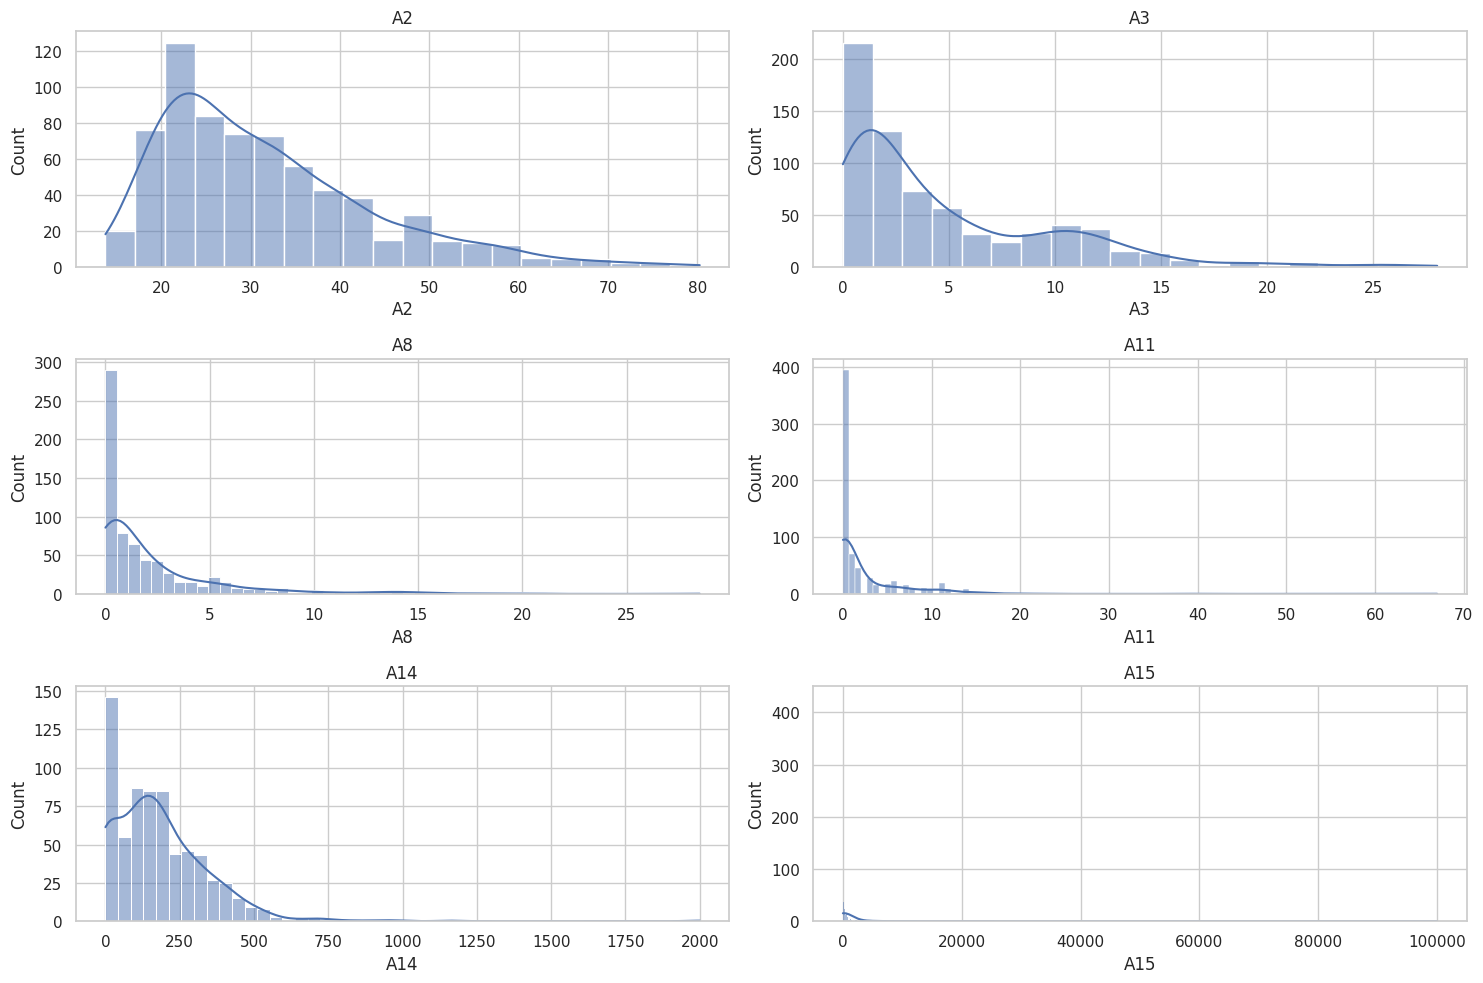

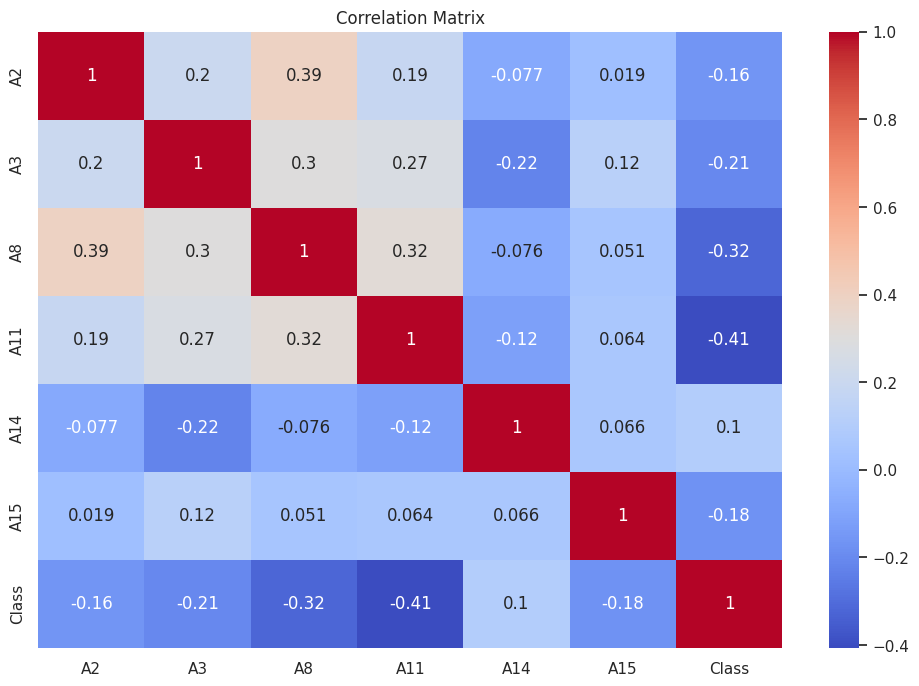

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Plotting histograms for continuous attributes
plt.figure(figsize=(15, 10))
for i, col in enumerate(continuous_attributes, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

# Plotting a heatmap for correlation between attributes
plt.figure(figsize=(12, 8))
sns.heatmap(df[continuous_attributes + ['Class']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [4]:
"""
DecisionTreeClassifier: Точність ≈ 81.64%
LogisticRegression: Точність ≈ 82.61%
KNeighborsClassifier (k-Nearest Neighbors): Точність ≈ 65.70%
З цих результатів видно, що модель логістичної регресії показала кращу точність, порівняно з деревом рішень та k-Nearest Neighbors. Така висока точність логістичної регресії може вказувати на те, що залежності у даних є лінійними. Дерево рішень також показало досить хороші результати, в той час як точність k-Nearest Neighbors була значно нижчою.
"""


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Training the DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
dt_pred = dt_classifier.predict(X_test)

# Evaluating the DecisionTreeClassifier
dt_accuracy = accuracy_score(y_test, dt_pred)
dt_report = classification_report(y_test, dt_pred)

# Training the LogisticRegression
lr_classifier = LogisticRegression(random_state=42, max_iter=1000)
lr_classifier.fit(X_train, y_train)
lr_pred = lr_classifier.predict(X_test)

# Evaluating the LogisticRegression
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_report = classification_report(y_test, lr_pred)

# Training the KNeighborsClassifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
knn_pred = knn_classifier.predict(X_test)

# Evaluating the KNeighborsClassifier
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_report = classification_report(y_test, knn_pred)

dt_accuracy, lr_accuracy, knn_accuracy  # Displaying the accuracies of the three models



/home/ihor/MLcourse/Decision tree/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.8164251207729468, 0.8260869565217391, 0.6570048309178744)

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Встановлення параметрів для GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Ініціалізація GridSearchCV з DecisionTreeClassifier
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# Пошук найкращих гіперпараметрів
grid_search.fit(X_train, y_train)

# Кращі знайдені параметри та точність
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Кращі параметри:", best_parameters)
print("Найкраща точність:", best_accuracy)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Кращі параметри: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Найкраща точність: 0.8406357388316152
